In [2]:
class BloomFilterCounter:
    def __init__(self, m, k):
        self.m = m
        self.k = k
        self.counters = [0] * m
        self.primes = [31, 37, 41, 43, 47, 53, 59, 61, 67, 71][:k]
        if len(self.primes) < k:
            raise ValueError("Не хватает простых чисел")

    def hash_function(self, s, prime):
        h = 0
        for char in s:
            h = (h * prime + ord(char)) % self.m
        return h

    def add(self, element):
        for prime in self.primes:
            index = self.hash_function(element, prime)
            self.counters[index] += 1

    def remove(self, element):
        indexes = {}
        for prime in self.primes:
            index = self.hash_function(element, prime)
            if index not in indexes:
                indexes[index] = 1
            else:
                indexes[index] += 1
        for index in indexes:
            if self.counters[index] < indexes[index]:
                return False
        for index in indexes:
            self.counters[index] -= indexes[index]
        return True

    def check(self, element):
        indexes = {}
        for prime in self.primes:
            index = self.hash_function(element, prime)
            if index not in indexes:
                indexes[index] = 1
            else:
                indexes[index] += 1
        for index in indexes:
            if self.counters[index] < indexes[index]:
                return False
        return True

    def union(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые m и k")
        new_filter = BloomFilterCounter(self.m, self.k)
        for i in range(self.m):
            new_filter.counters[i] = self.counters[i] + other.counters[i]
        return new_filter

    def intersection(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые m и k")
        new_filter = BloomFilterCounter(self.m, self.k)
        for i in range(self.m):
            new_filter.counters[i] = min(self.counters[i], other.counters[i])
        return new_filter

Результаты после добавления:
        FP rate after add (%)
m    k                       
1000 1                  96.54
     2                  97.52
     3                  97.52
     4                  97.52
     5                  97.52
2000 1                  88.68
     2                  95.06
     3                  97.30
     4                  97.52
     5                  97.52
3000 1                  78.42
     2                  89.60
     3                  94.96
     4                  96.50
     5                  97.12
4000 1                  68.08
     2                  80.20
     3                  89.80
     4                  94.46
     5                  96.26
5000 1                  61.90
     2                  72.06
     3                  83.50
     4                  90.20
     5                  93.10

Результаты после удаления:
        FP rate after remove (%)
m    k                          
1000 1                 97.325103
     2                100.000000
 

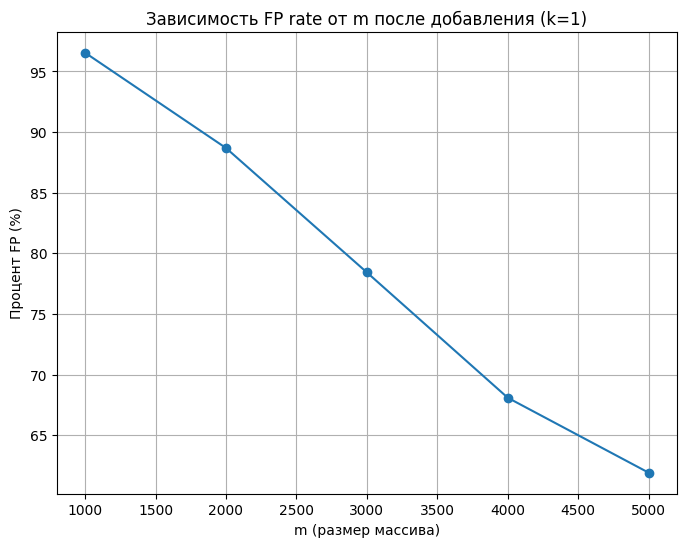

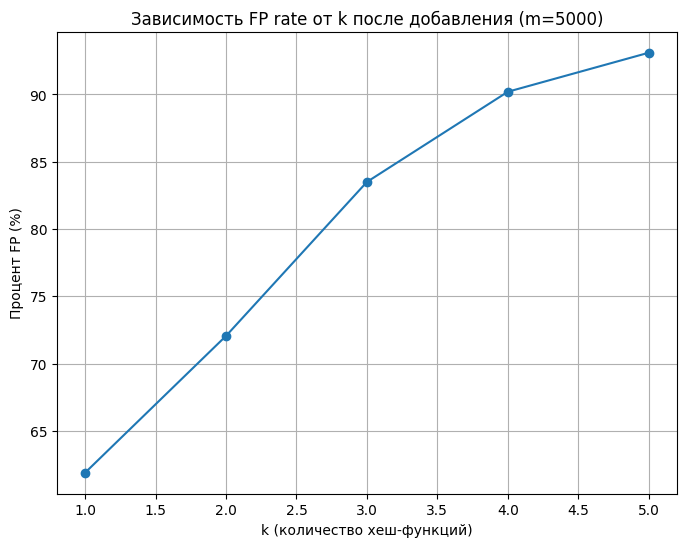

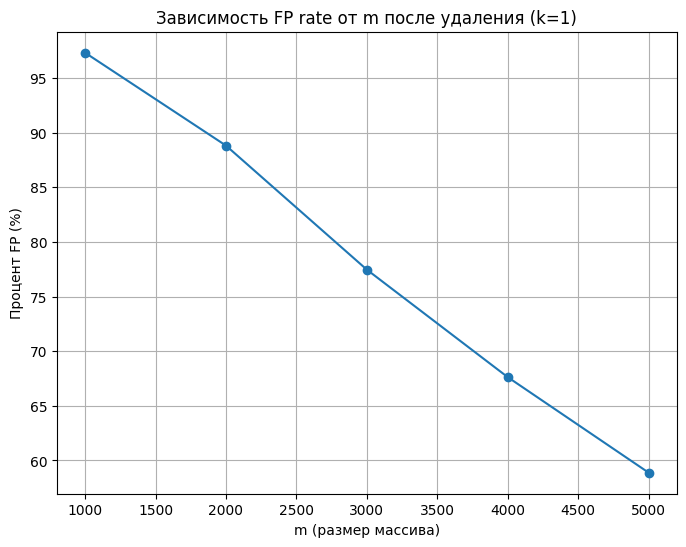

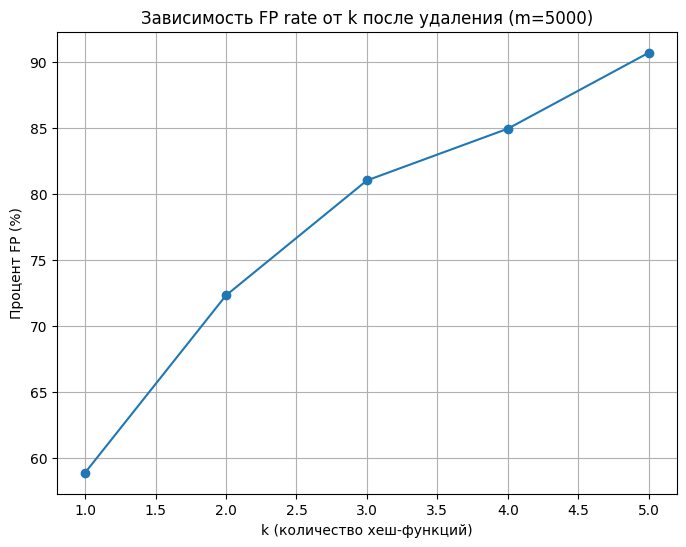

In [5]:
import random
import pandas as pd
import matplotlib.pyplot as plt


def false_positive_rate(cbf, train_words, test_words):
    false_positives = 0
    for word in test_words:
        if cbf.check(word) and word not in train_words:
            false_positives += 1
    return (false_positives / len(test_words)) * 100


with open('english_words_10k.txt', 'r') as file:
    words = [line.strip() for line in file.readlines()]
train_words = words[:5000]
test_words = words[5000:]

m_values = [1000, 2000, 3000, 4000, 5000]
k_values = [1, 2, 3, 4, 5]

results_add = {}
results_remove = {}

for m in m_values:
    for k in k_values:
        cbf = BloomFilterCounter(m, k)

        for word in train_words:
            cbf.add(word)
        fp_rate_add = false_positive_rate(cbf, train_words, test_words)
        results_add[(m, k)] = fp_rate_add

        remove_words = random.sample(test_words, 500)

        remove_words = [
            word for word in remove_words if word not in train_words]
        deleted_words = 0
        for word in remove_words:
            if cbf.remove(word):
                deleted_words += 1
        fp_rate_remove = deleted_words / len(remove_words) * 100
        results_remove[(m, k)] = fp_rate_remove

df_add = pd.DataFrame.from_dict(results_add, orient='index', columns=[
                                'FP rate after add (%)'])
df_add.index = pd.MultiIndex.from_tuples(df_add.index, names=['m', 'k'])
print("Результаты после добавления:")
print(df_add)

df_remove = pd.DataFrame.from_dict(results_remove, orient='index', columns=[
                                   'FP rate after remove (%)'])
df_remove.index = pd.MultiIndex.from_tuples(df_remove.index, names=['m', 'k'])
print("\nРезультаты после удаления:")
print(df_remove)

fixed_k = 1
fp_rates_m_add = [results_add[(m, fixed_k)] for m in m_values]
plt.figure(figsize=(8, 6))
plt.plot(m_values, fp_rates_m_add, marker='o')
plt.title(f'Зависимость FP rate от m после добавления (k={fixed_k})')
plt.xlabel('m (размер массива)')
plt.ylabel('Процент FP (%)')
plt.grid(True)

fixed_m = 5000
fp_rates_k_add = [results_add[(fixed_m, k)] for k in k_values]
plt.figure(figsize=(8, 6))
plt.plot(k_values, fp_rates_k_add, marker='o')
plt.title(f'Зависимость FP rate от k после добавления (m={fixed_m})')
plt.xlabel('k (количество хеш-функций)')
plt.ylabel('Процент FP (%)')
plt.grid(True)

fp_rates_m_remove = [results_remove[(m, fixed_k)] for m in m_values]
plt.figure(figsize=(8, 6))
plt.plot(m_values, fp_rates_m_remove, marker='o')
plt.title(f'Зависимость FP rate от m после удаления (k={fixed_k})')
plt.xlabel('m (размер массива)')
plt.ylabel('Процент FP (%)')
plt.grid(True)

fp_rates_k_remove = [results_remove[(fixed_m, k)] for k in k_values]
plt.figure(figsize=(8, 6))
plt.plot(k_values, fp_rates_k_remove, marker='o')
plt.title(f'Зависимость FP rate от k после удаления (m={fixed_m})')
plt.xlabel('k (количество хеш-функций)')
plt.ylabel('Процент FP (%)')
plt.grid(True)

In [6]:
import random


class Hasher:
    def __init__(self, initial_seed: int, output_bits: int):
        self.seed = initial_seed
        self.output_bits = output_bits
        self.modulus = 2 ** (output_bits + 5)

    def generate_hash(self, input_string: str) -> int:
        hash_value = self.seed
        for char in input_string:
            hash_value = (hash_value * 31 + ord(char)) % self.modulus
        return hash_value & ((1 << self.output_bits) - 1)


class QuotientFilterStruct:
    def __init__(self, quotient_bits: int, remainder_bits: int):
        self.q_bits = quotient_bits
        self.r_bits = remainder_bits
        self.size = 1 << quotient_bits
        self.slots = [{'occ': False, 'shift': False, 'cont': False, 'rem': None}
                      for _ in range(self.size)]
        self.hasher = Hasher(17, quotient_bits + remainder_bits)

    def _get_indices(self, full_hash: int):
        quotient = (full_hash >> self.r_bits) % self.size
        remainder = full_hash & ((1 << self.r_bits) - 1)
        return quotient, remainder

    def add(self, key: str):
        h = self.hasher.generate_hash(key)
        q, r = self._get_indices(h)

        self.slots[q]['occ'] = True

        idx = q
        while self.slots[idx]['rem'] is not None:
            idx = (idx + 1) % self.size

        if idx != q:
            self.slots[idx]['shift'] = True
            if self.slots[(idx - 1) % self.size]['rem'] is not None:
                self.slots[idx]['cont'] = True

        self.slots[idx]['rem'] = r

    def contains(self, key: str) -> bool:
        h = self.hasher.generate_hash(key)
        q, r = self._get_indices(h)

        idx = q
        while True:
            if self.slots[idx]['rem'] == r:
                return True
            if not self.slots[idx]['cont']:
                break
            idx = (idx + 1) % self.size

        return False

    def print_debug(self):
        print("Яч | Occ Shift Cont | Отпечаток")
        print("-----------------------------")
        for i, slot in enumerate(self.slots):
            rem = slot['rem'] if slot['rem'] is not None else '-'
            print(
                f"{i:3} |  {int(slot['occ'])}     {int(slot['shift'])}     {int(slot['cont'])}  | {rem}")

Тестируем q=8, r=4...
Тестируем q=8, r=6...
Тестируем q=8, r=8...
Тестируем q=8, r=10...
Тестируем q=10, r=4...
Тестируем q=10, r=6...
Тестируем q=10, r=8...
Тестируем q=10, r=10...
Тестируем q=12, r=4...
Тестируем q=12, r=6...
Тестируем q=12, r=8...
Тестируем q=12, r=10...

Результаты тестов:
     q   r     FPR
0    8   4  0.9054
1    8   6  0.6472
2    8   8  0.3640
3    8  10  0.1248
4   10   4  0.9338
5   10   6  0.7216
6   10   8  0.6960
7   10  10  0.1846
8   12   4  0.2370
9   12   6  0.1976
10  12   8  0.1566
11  12  10  0.0582


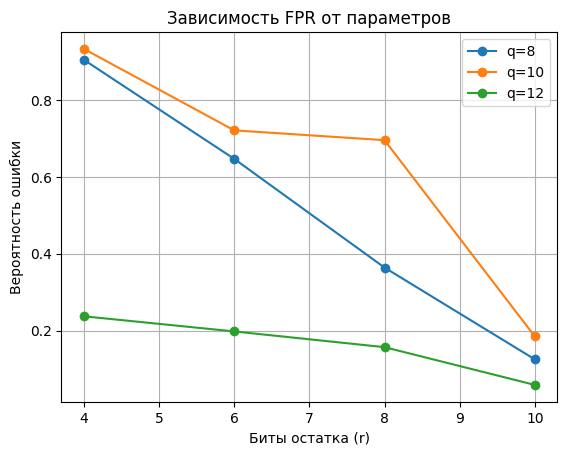

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from typing import List


def false_positive_rate(qf, train_words, test_words):
    false_positives = 0
    for word in test_words:
        if qf.contains(word) and word not in train_words:
            false_positives += 1
    return (false_positives / len(test_words)) * 100


def test_fpr(q_bits: int, r_bits: int, items=1000, tests=5000) -> float:
    qf = QuotientFilterStruct(q_bits, r_bits)

    for i in range(min(items, (1 << q_bits) - 1)):
        qf.add(str(i))

    false_pos = 0
    for _ in range(tests):
        if qf.contains(str(random.randint(10 ** 6, 10 ** 7))):
            false_pos += 1

    return false_pos / tests


def solve(q_options: List[int], r_options: List[int]):
    results = []

    for q in q_options:
        for r in r_options:
            print(f"Тестируем q={q}, r={r}...")
            fpr = test_fpr(q, r)
            results.append({'q': q, 'r': r, 'FPR': fpr})

    df = pd.DataFrame(results)
    print("\nРезультаты тестов:")
    print(df)

    for q in q_options:
        subset = df[df['q'] == q]
        plt.plot(subset['r'], subset['FPR'], label=f'q={q}', marker='o')

    plt.xlabel('Биты остатка (r)')
    plt.ylabel('Вероятность ошибки')
    plt.title('Зависимость FPR от параметров')
    plt.legend()
    plt.grid()
    plt.show()


q_params = [8, 10, 12]
r_params = [4, 6, 8, 10]
solve(q_params, r_params)